<a href="https://colab.research.google.com/github/qmeng222/MNIST-Playground/blob/main/weights/weight_changes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Quantify the weight changes during learning in two ways:
1.   Euclidean distance: weightChange
2.   Condition number: weightConds

In [69]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import copy # for copying and replacing

import matplotlib.pyplot as plt
import matplotlib_inline as inl
inl.backend_inline.set_matplotlib_formats("svg")

In [70]:
# import dataset:
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',') # np array
print(type(data))
print(data.shape)

# extract labels, then remove labels from data:
labels = data[:,0]
data   = data[:,1:]

# normalize the data to [0 1]:
dataNorm = data / np.max(data)

<class 'numpy.ndarray'>
(20000, 785)


In [71]:
# 1. np array -> torch tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long() # long for int

# use scikitlearn to split data
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size=.1)
print(train_data.shape, train_labels.shape, test_data.shape, test_labels.shape)

# 2. torch tensor -> torch dataset obj (combine)
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# 3. torch dataset obj -> torch dataloader obj (shuffle)
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

torch.Size([18000, 784]) torch.Size([18000]) torch.Size([2000, 784]) torch.Size([2000])


In [72]:
def createTheMNISTNet():

  # create a class for the model:
  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      self.input = nn.Linear(784,64)
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)

  # create the model instance
  net = mnistNet()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer (use SGD to slow down learning)
  optimizer = torch.optim.SGD(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [73]:
def function2trainTheModel(net,lossfun,optimizer):

  numepochs = 60

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []

  # store weight change and condition numbers for each layer:
  weightChange = np.zeros((numepochs,4)) # 4 layers
  weightConds  = np.zeros((numepochs,4))

  # loop over epochs
  for epochi in range(numepochs):

    # grab weights before training
    preW = []
    for p in net.named_parameters():
      if 'weight' in p[0]:
        preW.append( copy.deepcopy(p[1].data.numpy()) )
    # print("preW:", preW, "\n")

    # ------------------ TRAINING BEGINS -------------------

    net.train() # switch on training mode

    batchAcc  = []
    batchLoss = []
    # loop over training batches
    for X,y in train_loader:

      # forward pass
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # record
      batchLoss.append(loss.item())
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # ------------------ TEST BEGINS -------------------

    net.eval() # switch to eval mode

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

    # get the post-learning state of the weights
    for (i,p) in enumerate(net.named_parameters()):
      # print("👀", i, p)
      """
👀 1 ('input.bias', Parameter containing:
tensor([ 0.0496, -0.0243,  0.0477,  0.0604,  0.0121,  0.0542,  0.0763,  0.0162,
         0.0333, -0.0391,  0.0726,  0.0348, -0.0214,  0.0588, -0.0109,  0.0188,
        -0.0207, -0.0099,  0.0069,  0.0362,  0.0241,  0.0272,  0.0157, -0.0111,
         0.0772, -0.0024,  0.0479, -0.0215,  0.0661,  0.0429,  0.0303,  0.0469,
         0.0118,  0.0035,  0.0314, -0.0180,  0.0278,  0.0305,  0.0076,  0.0617,
         0.0438, -0.0041,  0.0475,  0.0008,  0.0250,  0.0130, -0.0184,  0.0361,
         0.0056, -0.0135, -0.0077,  0.0546,  0.0423, -0.0097, -0.0067,  0.0344,
         0.0206,  0.0250,  0.0155,  0.0607,  0.0072,  0.0191,  0.0611,  0.0488],
       requires_grad=True))

👀 2 ('fc1.weight', Parameter containing:
tensor([[-0.0886,  0.1092, -0.1482,  ...,  0.0548,  0.1044,  0.0899],
        [ 0.0182,  0.0890,  0.0953,  ..., -0.0154, -0.0465,  0.0812],
        [ 0.1024,  0.0026, -0.0417,  ...,  0.0195, -0.0388, -0.0842],
        ...,
        [-0.0694,  0.0304,  0.0708,  ..., -0.0339,  0.1308, -0.1283],
        [ 0.0806, -0.0053, -0.1042,  ..., -0.0115,  0.1268, -0.1794],
        [-0.0052, -0.0850,  0.0132,  ...,  0.0928, -0.0832, -0.0423]],
       requires_grad=True))

... ...
      """
      if 'weight' in p[0]:
        # use weightConds  = np.zeros((numepochs,4)) to store condition numbers:
        weightConds[epochi,int(i/2)]  = np.linalg.cond(p[1].data)
        # np.linalg.cond(p[1].data) calculates the condition number of the matrix p[1].data
        # int(i/2) -> layer

        # use weightChange = np.zeros((numepochs,4)) to store weight change:
        weightChange[epochi,int(i/2)] = np.linalg.norm( preW[int(i/2)]-p[1].data.numpy(), ord='fro')
        # np.linalg.norm() is a function for calculating the norm of a matrix
        # preW[int(i/2)]: weight from the beginning of the epoch (before trainning)
        # p[1].data.numpy(): current weight after training
        # ord='fro': calculate the Frobenius norm of the weight matrix, which is the sum of the squares of all the numeric values in a matrix

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net,weightChange,weightConds,preW

In [74]:
# scratch:
print(int(1/2))
print(int(2/2))
print(int(3/2))

0
1
1


# Run the model & plot the results:

In [75]:
# create the network
net,lossfun,optimizer = createTheMNISTNet()

# train the model
trainAcc,testAcc,losses,net,weightChange,weightConds,preW = function2trainTheModel(net,lossfun,optimizer)

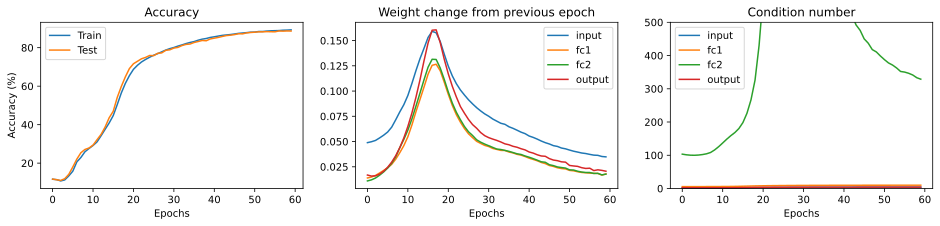

In [79]:
# Show the results!

# get a list of layer names
layername = []
for (i,p) in enumerate(net.named_parameters()):
  if 'weight' in p[0]:
    layername.append(p[0][:-7])

# set up the plot
fig,ax = plt.subplots(1,3,figsize=(16,3))

# accuracy
ax[0].plot(trainAcc)
ax[0].plot(testAcc)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy (%)')
ax[0].set_title('Accuracy')
ax[0].legend(['Train','Test'])

# weight changes
ax[1].plot(weightChange)
ax[1].set_xlabel('Epochs')
ax[1].set_title('Weight change from previous epoch')
ax[1].legend(layername)

# weight condition numbers
ax[2].plot(weightConds)
ax[2].set_xlabel('Epochs')
ax[2].set_title('Condition number')
ax[2].legend(layername)
ax[2].set_ylim([0,20])

plt.show()

👆Observations:
- Weights are changing most somewhere in the middle of training.
- Input layer has the largest weight changes in general.
- fc2 layer has higher condition numbers (>100) which means thay are approaching sparsity (sparsity in a learning system is when only a small number of features are actively used for learning).

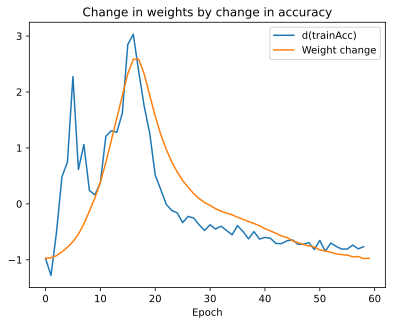

In [80]:
# final inspection: check the derivative of accuracy against the weight change
from scipy.stats import zscore # normalize for scaling offsets

# z-score to bring trainAcc and weightChange into the same range for visual convenience:
plt.plot(zscore(np.diff(trainAcc)),label='d(trainAcc)')
plt.plot(zscore(np.mean(weightChange,axis=1)),label='Weight change')
plt.legend()
plt.title('Change in weights by change in accuracy')
plt.xlabel('Epoch')
plt.show()

👆Observations:
- There's a huge burst of of learning in the beginning of training (1st blue spike), which is not really reflected by large changes in weights.
- As the model performance is changing rapidly (blue spike), the weights are also changing a lot (yellow spike).